In [9]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten
import matplotlib.pyplot as plt

# Dataset
The dataset contains `inputs` and `labels`.<br>
**inputs** _(list)_: Represents a slice of a spectrum with a window size of 20.<br>
**labels** _(bool)_: Indicates whether the slice contains a peak (1 for peak presence, 0 for absence)

In [10]:
with open('dataset.json', 'r') as fp:
    data = json.load(fp)
    inputs = np.array(data['inputs'])
    labels = np.array(data['labels'])

## Example plots
The plot below demostrates examples from the dataset by:<br>
- Plotting a spectrum containing a peak.<br>
- Plotting a spectrum without a peak.

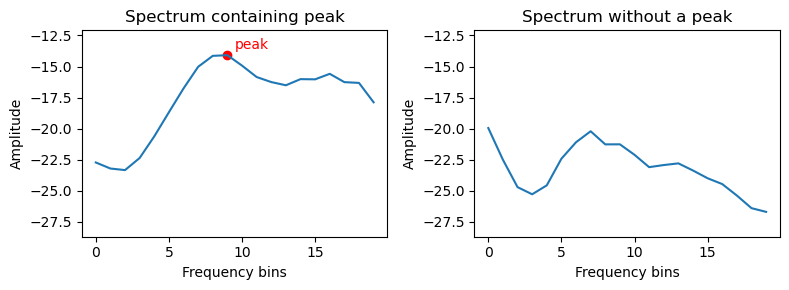

In [11]:
plt.figure(figsize=(8, 3))
y_min = min(min(inputs[7]), min(inputs[9])) - 2
y_max = max(max(inputs[7]), max(inputs[9])) + 2
peak_idx = np.argmax(inputs[7])
peak_mag = inputs[7][peak_idx]

# Spectrum containing a peak
plt.subplot(1, 2, 1)
plt.title('Spectrum containing peak')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[7])
plt.ylim(y_min, y_max)
plt.scatter(peak_idx, peak_mag, c='r')
plt.text(peak_idx + 0.5, peak_mag + 0.5, f'peak', c='r')

# Spectrum without a peak
plt.subplot(1, 2, 2)
plt.title('Spectrum without a peak')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[9])
plt.ylim(y_min, y_max)

plt.tight_layout()

## Data augmentation
The dataset requires augmentation to encompass various magnitude ranges and bandwidths.
To achieve this, the following operations can be performed on the dataset:<br>
- shifting
- scaling

### Shifting
Shifting is performed by adding an `offset` to the spectrum.

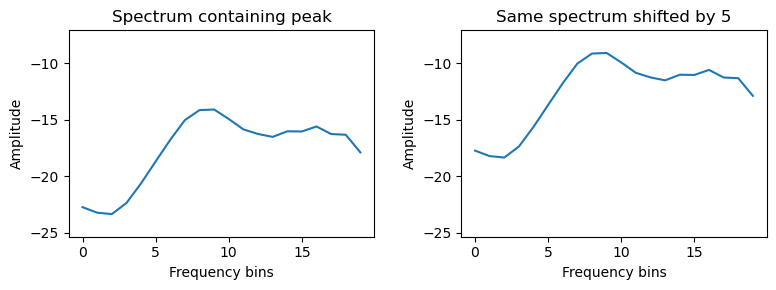

In [12]:
plt.figure(figsize=(8, 3))
y_min = min(inputs[7]) - 2
y_max = max(inputs[7]) + 2 + 5

# Spectrum containing a peak
plt.subplot(1, 2, 1)
plt.title('Spectrum containing peak')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[7])
plt.ylim(y_min, y_max)

# Same spectrum shifted by 5
plt.subplot(1, 2, 2)
plt.title('Same spectrum shifted by 5')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[7] + 5)
plt.ylim(y_min, y_max)

plt.tight_layout()

In [13]:
shifted = []
shifted_labels = []

for offset in range(-10, 10):
    for i in range(len(inputs)):
        shifted.append(inputs[i] + offset)
        shifted_labels.append(labels[i])
        
inputs = np.array(shifted)
labels = np.array(shifted_labels)

### Scaling
Scaling is performed by multiplying the spectrum by a scaling `factor` to the spectrum.

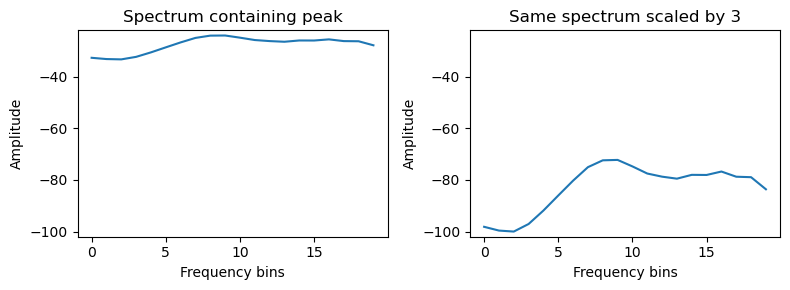

In [14]:
plt.figure(figsize=(8, 3))
y_min = min(min(inputs[7]) * 3, min(inputs[7])) - 2
y_max = max(max(inputs[7]) * 3, max(inputs[7])) + 2

# Spectrum containing a peak
plt.subplot(1, 2, 1)
plt.title('Spectrum containing peak')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[7])
plt.ylim(y_min, y_max)

# Same spectrum scaled by 3
plt.subplot(1, 2, 2)
plt.title('Same spectrum scaled by 3')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(inputs[7] * 3)
plt.ylim(y_min, y_max)

plt.tight_layout()

In [15]:
scaled = []
scaled_labels = []

for factor in np.arange(0.5, 3, step=0.1):
    for i in range(len(inputs)):
        scaled.append(inputs[i] * factor)
        scaled_labels.append(labels[i])

inputs = np.array(scaled)
labels = np.array(scaled_labels)

## Train test split
Split the dataset into `train`, `test` and `validation` set for training and evaluating the model.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
input_shape = X_train[0].shape

# Training

In [43]:
model = Sequential()

model.add(Input(shape=input_shape))
model.add(Conv1D(filters=20, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=40, kernel_size=5, activation='relu'))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [45]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 16, 20)            120       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 8, 20)            0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 4, 40)             4040      
                                                                 
 flatten_3 (Flatten)         (None, 160)               0         
                                                                 
 dense_7 (Dense)             (None, 20)                3220      
                                                                 
 dense_8 (Dense)             (None, 4)                 84        
                                                      

In [48]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10)

Epoch 1/10
15492/15492 [==============================] - 50s 3ms/step - loss: 0.1320 - accuracy: 0.9454 - val_loss: 0.1309 - val_accuracy: 0.9551
Epoch 2/10
15492/15492 [==============================] - 35s 2ms/step - loss: 0.0630 - accuracy: 0.9749 - val_loss: 0.0906 - val_accuracy: 0.9692
Epoch 3/10
15492/15492 [==============================] - 33s 2ms/step - loss: 0.0485 - accuracy: 0.9813 - val_loss: 0.0589 - val_accuracy: 0.9773
Epoch 4/10
15492/15492 [==============================] - 55s 4ms/step - loss: 0.0426 - accuracy: 0.9836 - val_loss: 0.0469 - val_accuracy: 0.9811
Epoch 5/10
15492/15492 [==============================] - 62s 4ms/step - loss: 0.0409 - accuracy: 0.9840 - val_loss: 0.0301 - val_accuracy: 0.9869
Epoch 6/10
15492/15492 [==============================] - 63s 4ms/step - loss: 0.0372 - accuracy: 0.9851 - val_loss: 0.0262 - val_accuracy: 0.9880
Epoch 7/10
15492/15492 [==============================] - 62s 4ms/step - loss: 0.0349 - accuracy: 0.9857 - val_loss: 0

# Evaluation
The model is evaluated on `X_test`.

In [18]:
prediction = model.predict(X_test)

1913/1913 [==============================] - 2s 842us/step


In [19]:
accuracy = accuracy_score(y_test, (prediction >= 0.5).astype(int))
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.86%


## Example plots
The plot below demostrates an example from the test set and prediction by the model:<br>

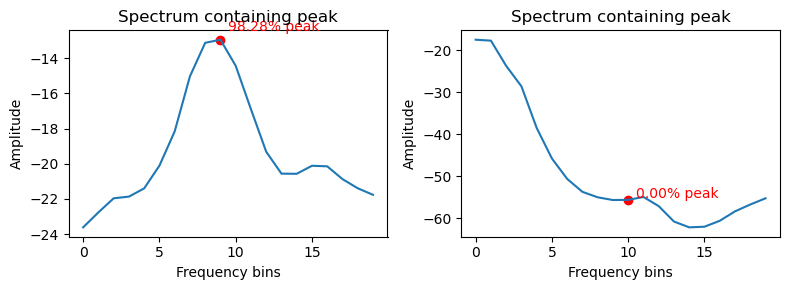

In [57]:
plt.figure(figsize=(8, 3))

# Spectrum from the test set containing a peak
peak_idx = np.argmax(X_test[90])
peak_mag = X_test[90][peak_idx]

plt.subplot(1, 2, 1)
plt.title('Spectrum containing peak')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(X_test[90])
plt.scatter(peak_idx, peak_mag, c='r')
plt.text(peak_idx + 0.5, peak_mag + 0.5, f'{prediction[90, 0] * 100:.2f}% peak', c='r')

# Spectrum from the test set without a peak
peak_idx = 10
peak_mag = X_test[93][peak_idx]

plt.subplot(1, 2, 2)
plt.title('Spectrum containing peak')
plt.xlabel('Frequency bins')
plt.ylabel('Amplitude')
plt.plot(X_test[93])
plt.scatter(peak_idx, peak_mag, c='r')
plt.text(peak_idx + 0.5, peak_mag + 0.5, f'{prediction[93, 0] * 100:.2f}% peak', c='r')

plt.tight_layout()

# Save the model

In [75]:
model.save("model/model.keras")